# Data preparation section

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# installed_packages = [
#     "opensmile",
#     "librosa",
#     "google",
#     "treelib",
#     "graphviz",
# ]

# for package in installed_packages:
#     !pip install {package}

In [3]:
import numpy as np
import pandas as pd
import json
import math
import random
import matplotlib.pyplot as plt

In [4]:
import opensmile

smile = opensmile.Smile(
#     feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
#     feature_set=opensmile.FeatureSet.GeMAPSv01b,
    feature_level=opensmile.FeatureLevel.Functionals,
)


In [5]:
import glob

try:
    files = glob.glob("../data/raw/RAVDESS/*/*.wav")
except:
    from google.colab import drive
    drive.mount('/content/gdrive')
    files = glob.glob("/content/gdrive/MyDrive/Colab Notebooks/Uni/IP/data/RAVDESS/*/*.wav")

In [6]:
file_name_to_emotion_mapping = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised",
}

In [7]:
emotion_to_positivity_mapping = {
    "neutral": "positive",
    "calm": "positive",
    "happy": "positive",
    "sad": "negative",
    "angry": "negative",
    "fearful": "negative",
    "disgust": "negative",
    "surprised": "positive",
}

In [8]:
SEED = 42

##### Data reading and pre-processing

In [9]:
from sklearn.model_selection import train_test_split

# def perform_3_way_split(data, labels, split, seed=42):
#     assert np.sum(split) == 100, "Split must be a 3-tuple with sum of 100"
#     train, val, test = (num/100 for num in split)
    
#     data_train_and_val, data_test, labels_train_and_val, labels_test = train_test_split(data, labels, test_size=test, random_state=seed, stratify=labels)
#     data_train, data_val, labels_train, labels_val = train_test_split(data_train_and_val, labels_train_and_val, test_size=val/(train+val), random_state=seed, stratify=labels_train_and_val)
#     return (data_train, data_val, data_test), (labels_train, labels_val, labels_test)

def perform_3_way_split(data, labels, split, seed=42):        
    assert np.sum(split) == 100, "Split must be a 3-tuple with sum of 100"
    train, val, test = (num/100 for num in split)
    
    data_train_and_val, data_test, labels_train_and_val, labels_test = train_test_split(data, labels, test_size=test, random_state=seed, stratify=labels)
    data_train, data_val, labels_train, labels_val = train_test_split(data_train_and_val, labels_train_and_val, test_size=val/(train+val), random_state=seed, stratify=labels_train_and_val)
    return (data_train, data_val, data_test), (labels_train, labels_val, labels_test)

def extract_audio_features(files):
    speech_data = smile.process_files(files)
    normalised_speech_data = (speech_data-speech_data.mean()) / speech_data.std()
    normalised_speech_data.dropna(axis='columns', inplace=True)
    return normalised_speech_data

In [10]:
emotions = [file_name_to_emotion_mapping[file.split("-")[-5]] for file in files]
files_split, emotions_split = perform_3_way_split(files, emotions, (80,10,10), SEED)

files_train, files_val, files_test = files_split
speeches_train, speeches_val, speeches_test = [extract_audio_features(file_set) for file_set in files_split]
emotions_train, emotions_val, emotions_test = emotions_split

In [11]:
emotions_binary_train = np.array([emotion_to_positivity_mapping[emotion] for emotion in emotions_train])
emotions_binary_val = np.array([emotion_to_positivity_mapping[emotion] for emotion in emotions_val])
emotions_binary_test = np.array([emotion_to_positivity_mapping[emotion] for emotion in emotions_test])

In [12]:
from collections import Counter

print(f"{len(speeches_train)=}\t\t{len(emotions_train)=}")
print(f"{len(speeches_val)=}\t\t{len(emotions_val)=}")
print(f"{len(speeches_test)=}\t\t{len(emotions_test)=}")

print(f"{Counter(emotions_train)=}")
print(f"{Counter(emotions_val)=}")
print(f"{Counter(emotions_test)=}")

len(speeches_train)=1152		len(emotions_train)=1152
len(speeches_val)=144		len(emotions_val)=144
len(speeches_test)=144		len(emotions_test)=144
Counter(emotions_train)=Counter({'angry': 154, 'happy': 154, 'calm': 154, 'sad': 154, 'disgust': 154, 'surprised': 153, 'fearful': 153, 'neutral': 76})
Counter(emotions_val)=Counter({'fearful': 20, 'calm': 19, 'happy': 19, 'angry': 19, 'sad': 19, 'surprised': 19, 'disgust': 19, 'neutral': 10})
Counter(emotions_test)=Counter({'surprised': 20, 'disgust': 19, 'angry': 19, 'fearful': 19, 'calm': 19, 'sad': 19, 'happy': 19, 'neutral': 10})


# Classifier comparison section

### Building classifiers

In [13]:
from locale import Error
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics

def fit_predict_and_score_classifier(classifier, data_train, data_val, labels_train, labels_val, label_set):
    classifier.fit(data_train, labels_train)
    results = {"train": {}, "val": {}}
    
    for set_type in ["train", "val"]:
        if set_type == "train":
            data = data_train
            labels = labels_train
        elif set_type == "val":
            data = data_val
            labels = labels_val
        else:
            raise Error("Undefined data set type")

        labels_predicted = classifier.predict(data)

        results[set_type]["predictions"] = labels_predicted
        results[set_type]["accuracy"] = metrics.accuracy_score(labels, labels_predicted)
        results[set_type]["precision"] = metrics.precision_score(labels, labels_predicted, average="macro", zero_division=1)
        results[set_type]["recall"] = metrics.recall_score(labels, labels_predicted, average="macro", zero_division=1)
        results[set_type]["F1"] = metrics.f1_score(labels, labels_predicted, average="macro", zero_division=1)

    return results

def create_result_table(results):
    first_key = list(results.keys())[0]
    second_key = list(results[first_key].keys())[0]
    table = pd.DataFrame(columns=["Classifier", "Set type"] + list(results[first_key][second_key].keys()))
    for classifier_name, classifier_data in results.items():
        for set_type, set_metrics in classifier_data.items():
              # Taken from (merging dicts) https://stackoverflow.com/questions/38987/how-do-i-merge-two-dictionaries-in-a-single-expression-in-python
            new_row = {"Classifier": classifier_name, "Set type": set_type} | set_metrics
            table = table.append(new_row, ignore_index=True)
    return table

# def create_result_table(results):
#     first_key = list(results.keys())[0]
#     second_key = list(results[first_key].keys())[0]
#     table = pd.DataFrame(columns=["Classifier", "Set type"] + list(results[first_key][second_key].keys()))
#     for classifier_name, classifier_data in results.items():
#         for set_type, set_metrics in classifier_data.items():
#               # Taken from (merging dicts) https://stackoverflow.com/questions/38987/how-do-i-merge-two-dictionaries-in-a-single-expression-in-python
#             new_row = pd.DataFrame({"Classifier": classifier_name, "Set type": set_type} | set_metrics)
#             table = pd.concat([table, new_row], ignore_index=True)
#     return table

def calculate_f1_scores_by_class(labels_predicted, labels):
    all_labels = sorted(list(set(labels)))
    matrix_dimension = range(len(set(labels)))
    matrix = metrics.confusion_matrix(labels, labels_predicted, labels=all_labels)

    recalls = [matrix[index, index] / row_sum for index, row_sum in enumerate(np.sum(matrix, axis=1))]
    precisions = [matrix[index, index] / column_sum for index, column_sum in enumerate(np.sum(matrix, axis=0))]

    f1_scores = {label: {} for label in all_labels}
    for index, label in enumerate(all_labels):
        f1_scores[label] = 2 * (precisions[index] * recalls[index]) / (precisions[index] + recalls[index])

    return f1_scores

In [14]:
# These parameters are repeated, so they are unwrapped while calling functions to reduce clutter
multi_class_parameters = (speeches_train, speeches_val, emotions_train, emotions_val, set(emotions))
binary_parameters = (speeches_train, speeches_val, emotions_binary_train, emotions_binary_val, set(["positive", "negative"]))
initial_classifier_results = {}
initial_classifier_results_binary = {}

In [15]:
dummy_classifier_most_frequent = DummyClassifier(strategy="most_frequent")
dummy_classifier_stratified = DummyClassifier(strategy="stratified")
logistic_regression = LogisticRegression(max_iter=1000)
svc = SVC()

### Multi-class classification

In [16]:
initial_classifier_results["dummy_classifier_most_frequent"] = fit_predict_and_score_classifier(dummy_classifier_most_frequent, *multi_class_parameters)

In [17]:
initial_classifier_results["dummy_classifier_stratified"] = fit_predict_and_score_classifier(dummy_classifier_stratified, *multi_class_parameters)

In [18]:
initial_classifier_results["logistic_regression"] = fit_predict_and_score_classifier(logistic_regression, *multi_class_parameters)

In [19]:
initial_classifier_results["svc"] = fit_predict_and_score_classifier(svc, *multi_class_parameters)

In [20]:
initial_classifier_results_table = create_result_table(initial_classifier_results)
display(initial_classifier_results_table)

C:\Users\Matas\AppData\Local\Temp\ipykernel_12296\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_12296\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_12296\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_12296\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_inde

,Classifier,Set type,predictions,accuracy,precision,recall,F1
0,dummy_classifier_most_frequent,train,"[angry, angry, angry, angry, angry, angry, ang...",0.133681,0.891710,0.125000,0.029479
1,dummy_classifier_most_frequent,val,"[angry, angry, angry, angry, angry, angry, ang...",0.131944,0.891493,0.125000,0.029141
2,dummy_classifier_stratified,train,"[neutral, calm, happy, neutral, calm, surprise...",0.135417,0.132095,0.132630,0.131919
3,dummy_classifier_stratified,val,"[surprised, fearful, sad, neutral, angry, surp...",0.104167,0.110624,0.103947,0.104544
4,logistic_regression,train,"[angry, happy, calm, happy, neutral, neutral, ...",0.762153,0.760435,0.760592,0.759600
5,logistic_regression,val,"[calm, angry, happy, calm, sad, angry, happy, ...",0.590278,0.596411,0.598026,0.594880
6,svc,train,"[angry, happy, calm, happy, surprised, calm, f...",0.802083,0.806050,0.783019,0.787734
7,svc,val,"[calm, angry, angry, calm, happy, angry, happy...",0.590278,0.592744,0.573355,0.573429


In [21]:
f1_scores = calculate_f1_scores_by_class(initial_classifier_results["svc"]["val"]["predictions"], emotions_val)
for emotion, score in f1_scores.items():
    print(f"{emotion}: {score}")

angry: 0.6451612903225806
calm: 0.7111111111111111
disgust: 0.6060606060606061
fearful: 0.5
happy: 0.5128205128205129
neutral: 0.33333333333333326
sad: 0.5789473684210527
surprised: 0.7


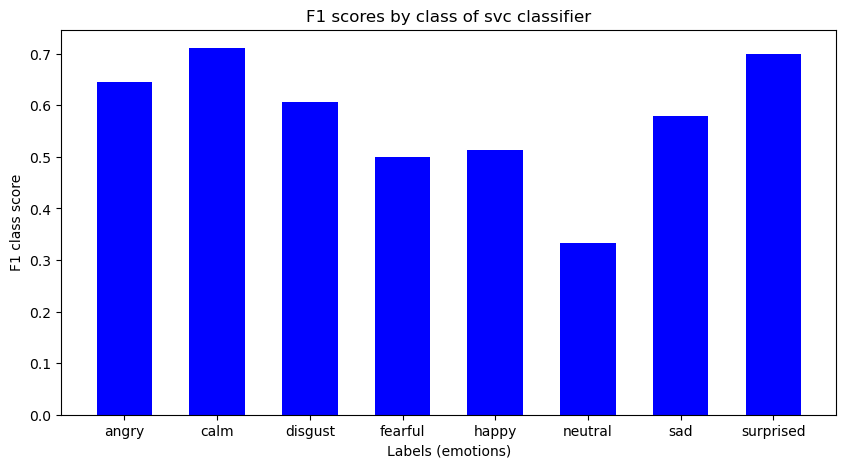

In [22]:
# Taken from https://www.geeksforgeeks.org/bar-plot-in-matplotlib/

import matplotlib.pyplot as plt

list_of_emotions = list(f1_scores.keys())
f1_score_values = list(f1_scores.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(list_of_emotions, f1_score_values, color ='blue', width = 0.6)
plt.xlabel("Labels (emotions)")
plt.ylabel("F1 class score")
plt.title("F1 scores by class of svc classifier")
plt.show()

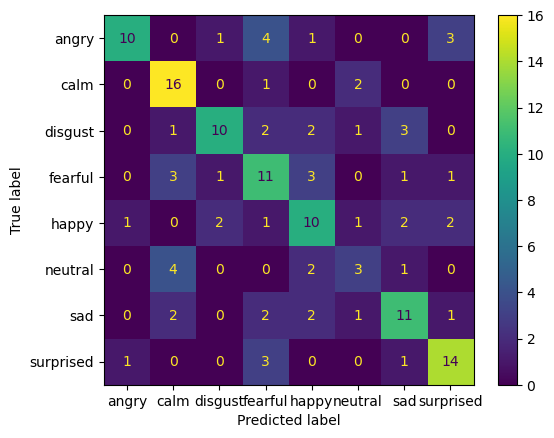

In [23]:
from sklearn import metrics

metrics.ConfusionMatrixDisplay.from_predictions(emotions_val, initial_classifier_results["svc"]["val"]["predictions"])
plt.show()

### Binary classification

In [24]:
initial_classifier_results_binary["dummy_classifier_most_frequent"] = fit_predict_and_score_classifier(dummy_classifier_most_frequent, *binary_parameters)

In [25]:
initial_classifier_results_binary["dummy_classifier_stratified"] = fit_predict_and_score_classifier(dummy_classifier_stratified, *binary_parameters)

In [26]:
initial_classifier_results_binary["logistic_regression"] = fit_predict_and_score_classifier(logistic_regression, *binary_parameters)

In [27]:
initial_classifier_results_binary["svc"] = fit_predict_and_score_classifier(svc, *binary_parameters)

In [28]:
initial_classifier_results_table_binary = create_result_table(initial_classifier_results_binary)
display(initial_classifier_results_table_binary)

C:\Users\Matas\AppData\Local\Temp\ipykernel_12296\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_12296\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_12296\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_12296\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_inde

,Classifier,Set type,predictions,accuracy,precision,recall,F1
0,dummy_classifier_most_frequent,train,"[negative, negative, negative, negative, negat...",0.533854,0.766927,0.500000,0.348048
1,dummy_classifier_most_frequent,val,"[negative, negative, negative, negative, negat...",0.534722,0.767361,0.500000,0.348416
2,dummy_classifier_stratified,train,"[positive, positive, negative, negative, posit...",0.485243,0.483559,0.483522,0.483496
3,dummy_classifier_stratified,val,"[positive, negative, positive, negative, posit...",0.506944,0.503125,0.503101,0.502893
4,logistic_regression,train,"[negative, positive, positive, positive, posit...",0.773438,0.772441,0.772099,0.772255
5,logistic_regression,val,"[positive, positive, negative, negative, negat...",0.687500,0.687500,0.688409,0.687123
6,svc,train,"[negative, positive, positive, positive, posit...",0.888021,0.887697,0.887210,0.887437
7,svc,val,"[positive, negative, negative, negative, negat...",0.756944,0.757081,0.753344,0.754278


In [29]:
f1_scores_binary = calculate_f1_scores_by_class(initial_classifier_results_binary["logistic_regression"]["val"]["predictions"], emotions_binary_val)
for emotion, score in f1_scores_binary.items():
    print(f"{emotion}: {score}")

negative: 0.6979865771812082
positive: 0.6762589928057554


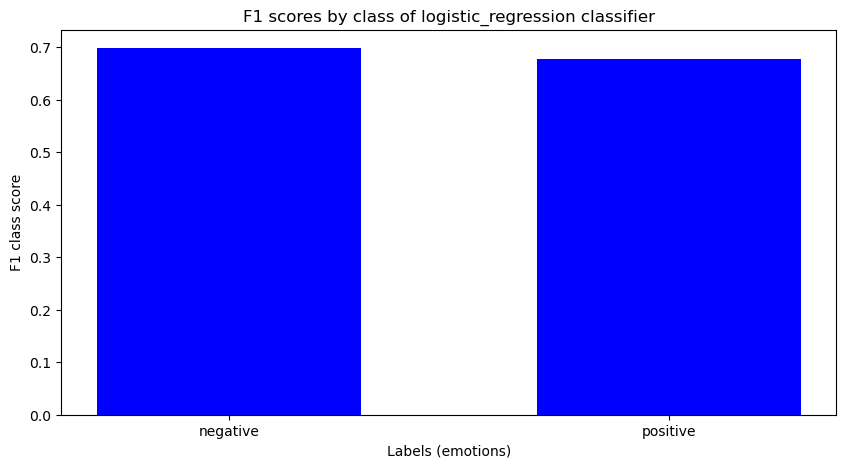

In [30]:
# Taken from https://www.geeksforgeeks.org/bar-plot-in-matplotlib/

import matplotlib.pyplot as plt

list_of_emotions_binary = list(f1_scores_binary.keys())
f1_score_values_binary = list(f1_scores_binary.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(list_of_emotions_binary, f1_score_values_binary, color ='blue', width = 0.6)
plt.xlabel("Labels (emotions)")
plt.ylabel("F1 class score")
plt.title("F1 scores by class of logistic_regression classifier")
plt.show()

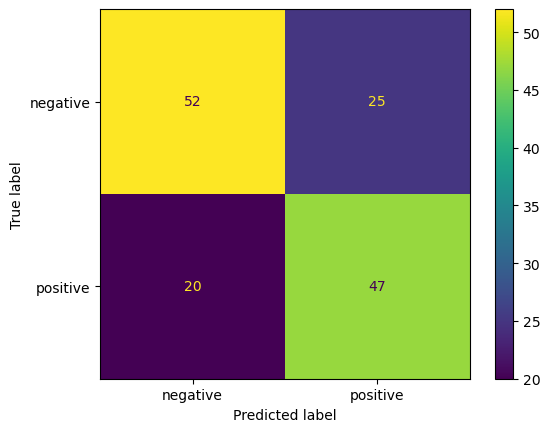

In [31]:
metrics.ConfusionMatrixDisplay.from_predictions(emotions_binary_val, initial_classifier_results_binary["logistic_regression"]["val"]["predictions"])
plt.show()

### Feature visualisation

In [32]:
# !jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

In [33]:
import treelib

def add_node(tree, feature, is_feature):
    feature_parent, delimiter, feature_name = feature.rpartition("_")
    
    if not tree.contains(feature_parent):
        add_node(tree, feature_parent, False)
    
    try:
        tree.create_node(tag=feature_name, identifier=feature, parent=feature_parent, data=is_feature)
    except treelib.exceptions.DuplicatedNodeIdError as error:
        # Such node already exists, potentially because recursive parent creation created it before reaching the node itself
        if is_feature:
            feature_tree.get_node(feature).data = True

feature_tree = treelib.Tree()

feature_tree.create_node(tag="ROOT", identifier="", data=False)

for column in speeches_train.columns:
    add_node(feature_tree, column, True)

In [34]:
# Taken from https://medium.com/dive-into-ml-ai/tree-data-visualization-with-treelib-71633f6fd8fb
import subprocess

feature_tree.to_graphviz("Feature hierarchy graph description.dot")
subprocess.call(["dot", "-Tpdf", "Feature hierarchy graph description.dot", "-o", "Feature hierarchy graph.pdf"])

0

In [35]:
# feature_tree.all_nodes()

In [36]:
feature_endings = []
analysis_by_endings = {}

feature_stems = []
analysis_by_stems = {}

for column in speeches_train.columns:
    feature_parent, delimiter, ending = column.rpartition("_")
    feature_endings.append(ending)
    feature_stems.append(feature_parent)
    
    if ending not in analysis_by_endings.keys():
        analysis_by_endings[ending] = {"features": []}
        
    if feature_parent not in analysis_by_stems.keys():
        analysis_by_stems[feature_parent] = {"features": []}
    
    analysis_by_endings[ending]["features"].append(column)
    analysis_by_stems[feature_parent]["features"].append(column)
    
print(Counter(feature_endings))
print()
print(Counter(feature_stems))
print()
print(analysis_by_stems.items())

Counter({'amean': 35, 'stddevNorm': 30, 'percentile20.0': 2, 'percentile50.0': 2, 'percentile80.0': 2, 'pctlrange0-2': 2, 'meanRisingSlope': 2, 'stddevRisingSlope': 2, 'meanFallingSlope': 2, 'stddevFallingSlope': 2, 'loudnessPeaksPerSec': 1, 'VoicedSegmentsPerSec': 1, 'MeanVoicedSegmentLengthSec': 1, 'StddevVoicedSegmentLengthSec': 1, 'MeanUnvoicedSegmentLength': 1, 'StddevUnvoicedSegmentLength': 1, 'dBp': 1})

Counter({'F0semitoneFrom27.5Hz_sma3nz': 10, 'loudness_sma3': 10, '': 6, 'spectralFlux_sma3': 2, 'mfcc1_sma3': 2, 'mfcc2_sma3': 2, 'mfcc3_sma3': 2, 'mfcc4_sma3': 2, 'jitterLocal_sma3nz': 2, 'shimmerLocaldB_sma3nz': 2, 'HNRdBACF_sma3nz': 2, 'logRelF0-H1-H2_sma3nz': 2, 'logRelF0-H1-A3_sma3nz': 2, 'F1frequency_sma3nz': 2, 'F1bandwidth_sma3nz': 2, 'F1amplitudeLogRelF0_sma3nz': 2, 'F2frequency_sma3nz': 2, 'F2bandwidth_sma3nz': 2, 'F2amplitudeLogRelF0_sma3nz': 2, 'F3frequency_sma3nz': 2, 'F3bandwidth_sma3nz': 2, 'F3amplitudeLogRelF0_sma3nz': 2, 'alphaRatioV_sma3nz': 2, 'hammarbergIndex

### Feature optimisation section

In [37]:
use_simplified_feature_selection_algorithm = False

In [38]:
classifier_for_feature_optimisation = svc
baseline_f1_score = initial_classifier_results["svc"]["val"]["F1"]

features_used_for_testing = 10_000 # 50 # 600

speeches_train_copy = speeches_train.copy()
speeches_train_copy.drop(speeches_train.columns[features_used_for_testing:], axis=1, inplace=True)
speeches_val_copy = speeches_val.copy()
speeches_val_copy.drop(speeches_val.columns[features_used_for_testing:], axis=1, inplace=True)

In [39]:
### Separated model to reduce time demands

from ipywidgets import IntProgress

if use_simplified_feature_selection_algorithm is True:
    
    endings_progress_bar = IntProgress(
        min=0,
        max=len(analysis_by_stems.keys())-1,
        description = f"0/{len(analysis_by_stems)-1} ending"
    )

    progress_bar = IntProgress(
        min=0,
        max=len(speeches_train_copy.columns)-1,
        description = f"0th feature"
    )

    inner_progress_bar = IntProgress(
        min=0,
        max=len(speeches_train.columns)-1,
        description = f"0/{len(speeches_train_copy.columns)-1}"
    )

    display(endings_progress_bar)
    display(progress_bar)
    display(inner_progress_bar)

    feature_pruning_data = []
    final_data_frame = None

    for stem_index, data in enumerate(list(analysis_by_stems.values())):
        print(data)

        progress_bar.value = 0
        progress_bar.max = len(speeches_train_copy.columns)-1
        inner_progress_bar.value = 0
        inner_progress_bar.max = len(speeches_train_copy.columns)-1
        endings_progress_bar.description = f"{stem_index}/{len(analysis_by_stems)-1} stem"

        for feature_index in range(len(speeches_train_copy.columns)-1): # -1 so that the last feature is not deleted and an empty DataFrame is passed
            progress_bar.description = f"{feature_index}/{len(speeches_train_copy.columns)-1} feature"

            # Setting the new baseline
            result = fit_predict_and_score_classifier(
                    classifier_for_feature_optimisation,
                    speeches_train_copy,
                    speeches_val_copy,
                    emotions_train,
                    emotions_val,
                    set(emotions)
                )
            max_f1_score = result["val"]["F1"]
            column_to_remove = None

            # Finding the worst F1-reducing feature
            inner_progress_bar.max = len(speeches_train_copy.columns)
            inner_progress_bar.value = 0

            for index, column in enumerate(speeches_train_copy.columns):
                inner_progress_bar.description = f"{index}/{len(speeches_train_copy.columns)-1}"

                result = fit_predict_and_score_classifier(
                    classifier_for_feature_optimisation,
                    speeches_train_copy.drop([column], axis=1),
                    speeches_val_copy.drop([column], axis=1),
                    emotions_train,
                    emotions_val,
                    set(emotions)
                )
                f1_score = result["val"]["F1"]

                if f1_score > max_f1_score:
                    max_f1_score = f1_score
                    column_to_remove = column

                inner_progress_bar.value += 1

            # Removing the worst feature
            if column_to_remove is not None:
                speeches_train_copy.drop([column_to_remove], axis=1, inplace=True)
                speeches_val_copy.drop([column_to_remove], axis=1, inplace=True)
                feature_pruning_data.append((column_to_remove, max_f1_score, max_f1_score - f1_score))
                progress_bar.value += 1
            else:
                progress_bar.value = progress_bar.max
                inner_progress_bar.value = inner_progress_bar.max
                final_data_frame = speeches_train_copy.copy()
                break

        endings_progress_bar.value += 1

In [40]:
### Full version (slow but checking everything)

from ipywidgets import IntProgress

if use_simplified_feature_selection_algorithm is False:

    progress_bar = IntProgress(
        min=0,
        max=len(speeches_train_copy.columns)-1,
        description = f"0th feature"
    )

    inner_progress_bar = IntProgress(
        min=0,
        max=len(speeches_train.columns)-1,
        description = f"0/{len(speeches_train_copy.columns)-1}"
    )

    display(progress_bar)
    display(inner_progress_bar)

    feature_pruning_data = []
    final_data_frame = None

    speeches_train_copy = speeches_train.copy()
    speeches_val_copy = speeches_val.copy()

    progress_bar.value = 0
    progress_bar.max = len(speeches_train_copy.columns)-1
    inner_progress_bar.value = 0
    inner_progress_bar.max = len(speeches_train_copy.columns)-1

    for feature_index in range(len(speeches_train_copy.columns)-1): # -1 so that the last feature is not deleted and an empty DataFrame is passed
        progress_bar.description = f"{feature_index}/{len(speeches_train_copy.columns)-1} feature"

        # Setting the new baseline
        result = fit_predict_and_score_classifier(
                classifier_for_feature_optimisation,
                speeches_train_copy,
                speeches_val_copy,
                emotions_train,
                emotions_val,
                set(emotions)
            )
        max_f1_score = result["val"]["F1"]
        column_to_remove = None

        # Finding the worst F1-reducing feature
        inner_progress_bar.max = len(speeches_train_copy.columns)
        inner_progress_bar.value = 0

        for index, column in enumerate(speeches_train_copy.columns):
            inner_progress_bar.description = f"{index}/{len(speeches_train_copy.columns)-1}"

            result = fit_predict_and_score_classifier(
                classifier_for_feature_optimisation,
                speeches_train_copy.drop([column], axis=1),
                speeches_val_copy.drop([column], axis=1),
                emotions_train,
                emotions_val,
                set(emotions)
            )
            f1_score = result["val"]["F1"]

            if f1_score > max_f1_score:
                max_f1_score = f1_score
                column_to_remove = column

            inner_progress_bar.value += 1

        # Removing the worst feature
        if column_to_remove is not None:
            speeches_train_copy.drop([column_to_remove], axis=1, inplace=True)
            speeches_val_copy.drop([column_to_remove], axis=1, inplace=True)
            feature_pruning_data.append((column_to_remove, max_f1_score, max_f1_score - f1_score))
            progress_bar.value += 1
        else:
            progress_bar.value = progress_bar.max
            inner_progress_bar.value = inner_progress_bar.max
            final_data_frame = speeches_train_copy.copy()
            break

IntProgress(value=0, description='0th feature', max=87)

IntProgress(value=0, description='0/87', max=87)

In [41]:
feature_pruning_data

[('spectralFluxV_sma3nz_stddevNorm', 0.5878815354966671, 0.032310840373626415),
 ('mfcc4_sma3_stddevNorm', 0.6008061781659593, 0.039601769832434575),
 ('slopeV500-1500_sma3nz_stddevNorm', 0.6181111727147532, 0.03222143699306668),
 ('shimmerLocaldB_sma3nz_amean', 0.6262865942804166, 0.008423540191158652),
 ('alphaRatioV_sma3nz_stddevNorm', 0.6336068233934088, 0.02188082096016941),
 ('F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
  0.6406898139322816,
  0.022305311008305018),
 ('mfcc3_sma3_stddevNorm', 0.6471928503695287, 0.022129802705861734),
 ('logRelF0-H1-A3_sma3nz_stddevNorm',
  0.6535605183471038,
  0.020506149998617884),
 ('F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
  0.6545457320840191,
  0.014719242454177772),
 ('jitterLocal_sma3nz_stddevNorm', 0.6775128025128025, 0.025204830638833498),
 ('slopeV0-500_sma3nz_stddevNorm', 0.6844270551091312, 0.01230567383842307),
 ('mfcc2_sma3_stddevNorm', 0.6973172660672661, 0.013363381198747026),
 ('logRelF0-H1-H2_sma3nz_stddevNorm',
  0.69

In [42]:
removed_columns = [entry[0] for entry in feature_pruning_data]
speeches_train_pruned = speeches_train.copy().drop(removed_columns, axis=1)
speeches_val_pruned = speeches_val.copy().drop(removed_columns, axis=1)
speeches_test_pruned = speeches_test.copy().drop(removed_columns, axis=1)

multi_class_pruned_parameters = (speeches_train_pruned, speeches_val_pruned, emotions_train, emotions_val, set(emotions))

In [43]:
print(len(speeches_train.columns), len(speeches_train_pruned.columns))

88 75


In [44]:
initial_classifier_results["svc_pruned"] = fit_predict_and_score_classifier(svc, *multi_class_parameters)

In [45]:
post_prunation_classifier_results_table = create_result_table(initial_classifier_results)
display(post_prunation_classifier_results_table)

C:\Users\Matas\AppData\Local\Temp\ipykernel_12296\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_12296\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_12296\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_12296\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_inde

,Classifier,Set type,predictions,accuracy,precision,recall,F1
0,dummy_classifier_most_frequent,train,"[angry, angry, angry, angry, angry, angry, ang...",0.133681,0.891710,0.125000,0.029479
1,dummy_classifier_most_frequent,val,"[angry, angry, angry, angry, angry, angry, ang...",0.131944,0.891493,0.125000,0.029141
2,dummy_classifier_stratified,train,"[neutral, calm, happy, neutral, calm, surprise...",0.135417,0.132095,0.132630,0.131919
3,dummy_classifier_stratified,val,"[surprised, fearful, sad, neutral, angry, surp...",0.104167,0.110624,0.103947,0.104544
4,logistic_regression,train,"[angry, happy, calm, happy, neutral, neutral, ...",0.762153,0.760435,0.760592,0.759600
5,logistic_regression,val,"[calm, angry, happy, calm, sad, angry, happy, ...",0.590278,0.596411,0.598026,0.594880
6,svc,train,"[angry, happy, calm, happy, surprised, calm, f...",0.802083,0.806050,0.783019,0.787734
7,svc,val,"[calm, angry, angry, calm, happy, angry, happy...",0.590278,0.592744,0.573355,0.573429
8,svc_pruned,train,"[angry, happy, calm, happy, surprised, calm, f...",0.802083,0.806050,0.783019,0.787734
9,svc_pruned,val,"[calm, angry, angry, calm, happy, angry, happy...",0.590278,0.592744,0.573355,0.573429


### Hyperparameter optimisation

In [46]:
from sklearn.model_selection import GridSearchCV

svc_parameters = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "C": [0.1, 1, 5, 10, 20, 50],
    "gamma": ["scale", "auto"],
    "shrinking": [True, False],
}

parametrised_svc = GridSearchCV(svc, svc_parameters)
parametrised_svc.fit(speeches_train_pruned, emotions_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 5, 10, 20, 50],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'shrinking': [True, False]})

In [47]:
parametrised_svc.cv_results_.items()

dict_items([('mean_fit_time', array([0.04608555, 0.06176271, 0.0573534 , 0.06087365, 0.07526217,
       0.0799098 , 0.06937113, 0.07200265, 0.04242663, 0.0540988 ,
       0.06099949, 0.05943084, 0.07575479, 0.07353692, 0.07157769,
       0.06849775, 0.11247964, 0.19588094, 0.05354676, 0.05383129,
       0.05851111, 0.05933933, 0.04738722, 0.04565582, 0.10776968,
       0.19035983, 0.05572801, 0.05828233, 0.06405931, 0.0596806 ,
       0.04488773, 0.04673553, 0.36571765, 0.59298368, 0.05543928,
       0.05430193, 0.07224236, 0.06577063, 0.03907366, 0.03673196,
       0.36058869, 0.58208795, 0.0528389 , 0.0528748 , 0.07205176,
       0.06643906, 0.03862815, 0.03862429, 0.53732276, 0.85651016,
       0.06119623, 0.05941439, 0.08006096, 0.07368789, 0.03763232,
       0.03804064, 0.56250734, 0.87149   , 0.05418162, 0.05188527,
       0.07299695, 0.06556759, 0.03707862, 0.03767257, 0.75347781,
       1.21407957, 0.06047649, 0.05669665, 0.07883725, 0.06947384,
       0.03742852, 0.03887305, 0

In [48]:
def convert_grid_search_results_to_data_frame(results_dict):
    params = results_dict["params"]
    means_scores = results_dict["mean_test_score"]
    std_scores = results_dict["std_test_score"]
    rank_scores = results_dict["rank_test_score"]
    
    table = pd.DataFrame(columns=["C", "Kernel", "Gamma", "Shrinking", "Score mean", "Score std", "Rank"])
    
    for parameters, mean, std, rank in zip(params, means_scores, std_scores, rank_scores):
        new_row = {"C": parameters["C"], "Kernel": parameters["kernel"], "Gamma": parameters["gamma"], "Shrinking": parameters["shrinking"],
                   "Score mean": mean, "Score std": std, "Rank": rank}
        table = table.append(new_row, ignore_index=True)
        
    sorted_table = table.sort_values(by=["Rank"]).reset_index()
    return sorted_table

def convert_grid_search_results_data_frame_to_latex(results):
    latex_string = ""
    boldface_columns = []
    for column in results.columns:
        boldface_column = ""
        boldface_column += "\\textbf{"
        boldface_column += column
        boldface_column += "}"
        boldface_columns.append(boldface_column)
    latex_string += " & ".join(boldface_columns)
    latex_string += " \\\\\n"
    latex_string += "\t\t\\midrule\n"

    for index in range(len(results)):
        row = results.iloc[index]
        for column_name in ["C", "Kernel", "Gamma", "Shrinking", "Score mean", "Score std", "Rank"]:
            if column_name == "C":
                latex_string += f"\t\t{row[column_name]}"
            elif "Score" in column_name:
                latex_string += f" & {row[column_name]:.4f}"
            else:
                latex_string += f" & {row[column_name]}"
        latex_string += "\\\\\n"
    
    return latex_string

In [49]:
grid_search_results_table = convert_grid_search_results_to_data_frame(parametrised_svc.cv_results_)
display(grid_search_results_table)

C:\Users\Matas\AppData\Local\Temp\ipykernel_12296\2989405021.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_12296\2989405021.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_12296\2989405021.py:12: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_12296\2989405021.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t

,index,C,Kernel,Gamma,Shrinking,Score mean,Score std,Rank
0,44,5.0,rbf,auto,True,0.665790,0.012212,1
1,45,5.0,rbf,auto,False,0.665790,0.012212,1
2,36,5.0,rbf,scale,True,0.665786,0.015072,3
3,37,5.0,rbf,scale,False,0.665786,0.015072,3
4,60,10.0,rbf,auto,True,0.664920,0.018702,5
...,...,...,...,...,...,...,...,...
91,95,50.0,sigmoid,auto,False,0.352419,0.019438,91
92,3,0.1,poly,scale,False,0.287378,0.036863,93
93,2,0.1,poly,scale,True,0.287378,0.036863,93
94,11,0.1,poly,auto,False,0.285643,0.034981,95


In [50]:
print(convert_grid_search_results_data_frame_to_latex(grid_search_results_table))

\textbf{index} & \textbf{C} & \textbf{Kernel} & \textbf{Gamma} & \textbf{Shrinking} & \textbf{Score mean} & \textbf{Score std} & \textbf{Rank} \\
		\midrule
		5.0 & rbf & auto & True & 0.6658 & 0.0122 & 1\\
		5.0 & rbf & auto & False & 0.6658 & 0.0122 & 1\\
		5.0 & rbf & scale & True & 0.6658 & 0.0151 & 3\\
		5.0 & rbf & scale & False & 0.6658 & 0.0151 & 3\\
		10.0 & rbf & auto & True & 0.6649 & 0.0187 & 5\\
		10.0 & rbf & auto & False & 0.6649 & 0.0187 & 5\\
		10.0 & rbf & scale & True & 0.6623 & 0.0214 & 7\\
		10.0 & rbf & scale & False & 0.6623 & 0.0214 & 7\\
		20.0 & rbf & scale & False & 0.6536 & 0.0233 & 9\\
		20.0 & rbf & scale & True & 0.6536 & 0.0233 & 9\\
		20.0 & rbf & auto & True & 0.6528 & 0.0247 & 11\\
		20.0 & rbf & auto & False & 0.6528 & 0.0247 & 11\\
		50.0 & rbf & scale & False & 0.6510 & 0.0224 & 13\\
		50.0 & rbf & scale & True & 0.6510 & 0.0224 & 13\\
		50.0 & rbf & auto & False & 0.6502 & 0.0237 & 15\\
		50.0 & rbf & auto & True & 0.6502 & 0.0237 & 15\\
		20.0 & 

In [51]:
optimised_svc = parametrised_svc.best_estimator_
optimised_parameters = parametrised_svc.best_params_
optimised_parameters

{'C': 5, 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': True}

In [52]:
initial_classifier_results["svc_optimised"] = fit_predict_and_score_classifier(optimised_svc, *multi_class_parameters)

In [53]:
post_optimisation_classifier_results_table = create_result_table(initial_classifier_results)
display(post_optimisation_classifier_results_table)

C:\Users\Matas\AppData\Local\Temp\ipykernel_12296\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_12296\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_12296\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_12296\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_inde

,Classifier,Set type,predictions,accuracy,precision,recall,F1
0,dummy_classifier_most_frequent,train,"[angry, angry, angry, angry, angry, angry, ang...",0.133681,0.891710,0.125000,0.029479
1,dummy_classifier_most_frequent,val,"[angry, angry, angry, angry, angry, angry, ang...",0.131944,0.891493,0.125000,0.029141
2,dummy_classifier_stratified,train,"[neutral, calm, happy, neutral, calm, surprise...",0.135417,0.132095,0.132630,0.131919
3,dummy_classifier_stratified,val,"[surprised, fearful, sad, neutral, angry, surp...",0.104167,0.110624,0.103947,0.104544
4,logistic_regression,train,"[angry, happy, calm, happy, neutral, neutral, ...",0.762153,0.760435,0.760592,0.759600
5,logistic_regression,val,"[calm, angry, happy, calm, sad, angry, happy, ...",0.590278,0.596411,0.598026,0.594880
6,svc,train,"[angry, happy, calm, happy, surprised, calm, f...",0.802083,0.806050,0.783019,0.787734
7,svc,val,"[calm, angry, angry, calm, happy, angry, happy...",0.590278,0.592744,0.573355,0.573429
8,svc_pruned,train,"[angry, happy, calm, happy, surprised, calm, f...",0.802083,0.806050,0.783019,0.787734
9,svc_pruned,val,"[calm, angry, angry, calm, happy, angry, happy...",0.590278,0.592744,0.573355,0.573429


# Neural network section

### Spectrogram creation

In [ ]:
# import librosa
# from IPython.display import Audio
# from sklearn import metrics

# # def crop_audio(audio):
# #     max_index = len(audio)-1
# #     start = random.randint(0, max_index // 4)
# #     end = random.randint(start * 2, max_index)
# #     cropped_audio = audio[start:end]
# #     return cropped_audio

# # Taken from https://medium.com/analytics-vidhya/adding-noise-to-audio-clips-5d8cee24ccb8
# def add_noise_to_audio(audio):
#     std = math.sqrt(np.mean(audio**2))
#     noise = np.random.normal(0, std, audio.shape[0])
#     noisy_signal = audio + noise
#     return noisy_signal

# # Taken from https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
# def create_mel_spectrogram_file(spectrogram, sampling_rate, hop_length, index, augmentation):
#     db_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
#     librosa.display.specshow(db_spectrogram, sr=sampling_rate, hop_length=hop_length, x_axis="time", y_axis="mel");
#     plt.colorbar(format="%+2.0f dB")
#     plt.title("Speech mel-spectrogram")
#     plt.xlabel("Time, s")
#     plt.ylabel("Frequency, Hz")
#     plt.savefig(f"spectrograms/{index}_{emotions[index]}_{augmentation}.pdf")
#     plt.clf()
#     return spectrogram

# # Taken from https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
# def produce_mel_spectrograms(files, hop_length=256, frameSize=512, n_mels=128):
#     spectrograms = []
#     emotions = []
#     max_audio_length = 0
#     audio_data = []
    
#     for file in files:
#         audio, sampling_rate = librosa.load(file)
#         max_audio_length = max(max_audio_length, audio.shape[0])
#         emotion = file_name_to_emotion_mapping[file.split("-")[-5]]
#         audio_data.append((audio, sampling_rate, emotion))
    
#     for index, (audio, sampling_rate, emotion) in enumerate(audio_data):
#         audio = librosa.util.fix_length(audio, size=max_audio_length)
# #         cropped_audio = crop_audio(audio)
#         noisy_audio = add_noise_to_audio(audio)
        
# #         print(index)
# #         display(Audio(data=audio, rate=sampling_rate))
# #         display(Audio(data=cropped_audio, rate=sampling_rate))
# #         display(Audio(data=noisy_audio, rate=sampling_rate))
        
#         for augmentation in ["original", "Gaussian noise"]:
#             input_audio = noisy_audio if augmentation == "Gaussian noise" else audio
#             spectrogram = librosa.feature.melspectrogram(y=input_audio, sr=sampling_rate, n_fft=frameSize, hop_length=hop_length, n_mels=n_mels)
# #             create_mel_spectrogram_file(spectrogram, sampling_rate, hop_length, index, augmentation)

#             spectrograms.append(spectrogram)
#             emotions.append(emotion)

#     return np.array(spectrograms), np.array(emotions)

In [ ]:
import librosa
from IPython.display import Audio
from sklearn import metrics

# def crop_audio(audio):
#     max_index = len(audio)-1
#     start = random.randint(0, max_index // 4)
#     end = random.randint(start * 2, max_index)
#     cropped_audio = audio[start:end]
#     return cropped_audio

# Taken from https://medium.com/analytics-vidhya/adding-noise-to-audio-clips-5d8cee24ccb8
def add_noise_to_audio(audio):
    std = math.sqrt(np.mean(audio**2))
    noise = np.random.normal(0, std, audio.shape[0])
    noisy_signal = audio + noise
    return noisy_signal

# Taken from https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
def save_mel_spectrogram_file(spectrogram, sampling_rate, hop_length, index, augmentation):
    db_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    librosa.display.specshow(db_spectrogram, sr=sampling_rate, hop_length=hop_length, x_axis="time", y_axis="mel");
    plt.colorbar(format="%+2.0f dB")
    plt.title("Speech mel-spectrogram")
    plt.xlabel("Time, s")
    plt.ylabel("Frequency, Hz")
    plt.savefig(f"spectrograms/{index}_{emotions[index]}_{augmentation}.pdf")
    plt.clf()
    return spectrogram

# Taken from https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
def create_mel_spectrograms(files_split, emotions_split, hop_length=256, frameSize=512, n_mels=128, save_spectrogram_files=False):
    max_audio_length = 0
    audio_data_train, audio_data_val, audio_data_test = [], [], []
    audio_data_sets = audio_data_train, audio_data_val, audio_data_test
    spectrograms_train, spectrograms_val, spectrograms_test = [], [], []
    spectrograms = spectrograms_train, spectrograms_val, spectrograms_test
    
    # Training set is expanded with noisy data, thus, the labels need to be expanded as well
    emotions_expanded_train = []
    
    for file_set, audio_data_set in zip(files_split, audio_data_sets):
        for file in file_set:
            audio, sampling_rate = librosa.load(file)
            max_audio_length = max(max_audio_length, audio.shape[0])
            audio_data_set.append((audio, sampling_rate))
            
    for audio_data_set, spectrogram_set, emotion_set, set_name in zip(audio_data_sets, spectrograms, emotions_split, ["Train", "Val", "Test"]):
        for index, (audio_data, emotion) in enumerate(zip(audio_data_set, emotion_set)):
            audio, sampling_rate = audio_data
            audio = librosa.util.fix_length(audio, size=max_audio_length)
            spectrogram = librosa.feature.melspectrogram(y=audio, sr=sampling_rate, n_fft=frameSize, hop_length=hop_length, n_mels=n_mels)
            spectrogram_set.append(spectrogram)
            if save_spectrogram_files:
                create_mel_spectrogram_file(spectrogram, sampling_rate, hop_length, f"{set_name}{index}", "original")
            
            if set_name == "Train":
                noisy_audio = add_noise_to_audio(audio)
                noisy_spectrogram = librosa.feature.melspectrogram(y=noisy_audio, sr=sampling_rate, n_fft=frameSize, hop_length=hop_length, n_mels=n_mels)
                spectrogram_set.append(noisy_spectrogram)
                # Might be better to just duplicate the array separately??? ##############################################################################################################################################################################
                emotions_expanded_train.append(emotion)
                emotions_expanded_train.append(emotion)
                if save_spectrogram_files:
                    create_mel_spectrogram_file(spectrogram, sampling_rate, hop_length, f"{set_name}{index}", "Gaussian noise")

    spectrograms = [np.array(spectrogram_set) for spectrogram_set in spectrograms]
    return spectrograms, np.array(emotions_expanded_train)

def add_spectrogram_preprocessing(spectrograms):
    normalised_spectrograms = (spectrograms-spectrograms.mean()) / spectrograms.std()
    spectrograms_with_single_channel = np.expand_dims(normalised_spectrograms, axis=1)
    return spectrograms_with_single_channel

In [ ]:
print(f"Sampling rate: {librosa.load(files[0])[1]}")

In [ ]:
spectrograms_split, emotions_expanded_train = create_mel_spectrograms(files_split, emotions_split)

In [ ]:
spectrograms_train, spectrograms_val, spectrograms_test = [add_spectrogram_preprocessing(spectrogram_set) for spectrogram_set in spectrograms_split]

In [ ]:
emotion_to_number_mapping = {emotion: int(number)-1 for number, emotion in file_name_to_emotion_mapping.items()}

emotions_numeric_train = np.array([emotion_to_number_mapping[emotion] for emotion in emotions_expanded_train])
emotions_numeric_val = np.array([emotion_to_number_mapping[emotion] for emotion in emotions_val])
emotions_numeric_test = np.array([emotion_to_number_mapping[emotion] for emotion in emotions_test])

emotions_expanded_binary_train = np.array([emotion_to_positivity_mapping[emotion] for emotion in emotions_expanded_train])

emotions_numeric_binary_train = np.array([1 if emotion == "positive" else 0 for emotion in spectrogram_emotions_binary_train])
emotions_numeric_binary_val = np.array([1 if emotion == "positive" else 0 for emotion in emotions_binary_val])
emotions_numeric_binary_test = np.array([1 if emotion == "positive" else 0 for emotion in emotions_binary_test])

In [ ]:
for s in [spectrograms_train, spectrograms_val, spectrograms_test]:
    print(s.shape)
    
for e in [emotions_numeric_train, emotions_numeric_val, emotions_numeric_test]:
    print(e.shape)

### Setting up DataSet and DataLoader

In [ ]:
import torch
import torch.nn.functional as F
import datetime
from torch.utils.tensorboard import SummaryWriter

In [ ]:
device = torch.device("cpu") # torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
torch.cuda.empty_cache()

In [ ]:
spectrograms_tensor_train = torch.from_numpy(spectrograms_train).float()
spectrograms_tensor_val = torch.from_numpy(spectrograms_val).float()
spectrograms_tensor_test = torch.from_numpy(spectrograms_test).float()

emotions_tensor_train = torch.from_numpy(emotions_numeric_train).long()
emotions_tensor_val = torch.from_numpy(emotions_numeric_val).long()
emotions_tensor_test = torch.from_numpy(emotions_numeric_test).long()

emotions_binary_tensor_train = torch.from_numpy(emotions_numeric_binary_train).long()
emotions_binary_tensor_val = torch.from_numpy(emotions_numeric_binary_val).long()
emotions_binary_tensor_test = torch.from_numpy(emotions_numeric_binary_test).long()

spectrogram_dimensions = spectrograms_tensor_train.size()[1:]

In [ ]:
spectrograms_tensor_train.size()

In [ ]:
batch_size = 4 #16

spectrogram_dataset_train = torch.utils.data.TensorDataset(spectrograms_tensor_train, emotions_tensor_train)
spectrogram_dataset_val = torch.utils.data.TensorDataset(spectrograms_tensor_val, emotions_tensor_val)
spectrogram_dataset_binary_train = torch.utils.data.TensorDataset(spectrograms_tensor_train, emotions_binary_tensor_train)
spectrogram_dataset_binary_val = torch.utils.data.TensorDataset(spectrograms_tensor_val, emotions_binary_tensor_val)
    
spectrogram_loader_train = torch.utils.data.DataLoader(spectrogram_dataset_train, batch_size=batch_size, shuffle=True)
spectrogram_loader_val = torch.utils.data.DataLoader(spectrogram_dataset_val, batch_size=batch_size, shuffle=False)
spectrogram_loader_binary_train = torch.utils.data.DataLoader(spectrogram_dataset_binary_train, batch_size=batch_size, shuffle=True)
spectrogram_loader_binary_val = torch.utils.data.DataLoader(spectrogram_dataset_binary_val, batch_size=batch_size, shuffle=False)

In [ ]:
number_to_emotion_mapping = {int(file_name)-1: emotion for file_name, emotion in file_name_to_emotion_mapping.items()}
number_to_emotion_mapping_binary = {0: "negative", 1: "positive"}

### Multi Layered Perceptron

##### Spectrograms as input

In [ ]:
class PerceptronSpectrogramModel(torch.nn.Module):

    def __init__(self):
        super(PerceptronSpectrogramModel, self).__init__()
        
        self.linear1 = torch.nn.Linear(np.prod(spectrogram_dimensions), 10)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(10, 8)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

### Convolutional Neural Network

In [ ]:
convoluted_dimensions = np.array(spectrogram_dimensions)
print(convoluted_dimensions)
convoluted_dimensions -= (3 - 1)
convoluted_dimensions -= (3 - 1)
convoluted_dimensions //= 2
convoluted_dimensions -= (3 - 1)
convoluted_dimensions -= (3 - 1)
convoluted_dimensions //= 2
convoluted_dimensions[0] = 1
print(convoluted_dimensions)
print(np.prod(convoluted_dimensions))

In [ ]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 4, 3)
        self.conv2 = torch.nn.Conv2d(4, 8, 3)
        self.conv3 = torch.nn.Conv2d(8, 16, 3)
        self.conv4 = torch.nn.Conv2d(16, 16, 3)
        self.fc1 = torch.nn.Linear(16 * np.prod(convoluted_dimensions), 32)
        self.fc2 = torch.nn.Linear(32, len(set(emotions)))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
class BinaryCNN(torch.nn.Module):

    def __init__(self):
        super(BinaryCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 4, 3)
        self.conv2 = torch.nn.Conv2d(4, 8, 3)
        self.conv3 = torch.nn.Conv2d(8, 16, 3)
        self.conv4 = torch.nn.Conv2d(16, 16, 3)
        self.fc1 = torch.nn.Linear(16 * np.prod(convoluted_dimensions), 32)
        self.fc2 = torch.nn.Linear(32, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### Neural network training

In [ ]:
# model = PerceptronSpectrogramModel()
cnn = CNN()
binary_cnn = BinaryCNN()

cnn.parameters

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

cnn_optimizer = torch.optim.Adam(cnn.parameters(), lr=0.00005) #### TEMPORARILY INCRESEAD FOR QUICKER RUNTIME
binary_cnn_optimizer = torch.optim.Adam(binary_cnn.parameters(), lr=0.00005) #### TEMPORARILY INCRESEAD FOR QUICKER RUNTIME

In [ ]:
# Potentially to delete, but should fix TensorBoard problems
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [ ]:
def calculate_accuracy(model, inputs, labels):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    output_predictions = torch.nn.Softmax(dim=1)(outputs).argmax(1)
    correct_count = torch.sum((output_predictions == labels)).item()
    accuracy = correct_count / len(labels)
    return accuracy

# Taken from https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
def calculate_class_accuracy(model, inputs, labels, use_binary):
    inputs = inputs.to(device)
    outputs = model(inputs)
    output_predictions = torch.nn.Softmax(dim=1)(outputs).argmax(1)
    output_predictions = output_predictions.to("cpu")
    if use_binary is False:
        output_emotions = np.array([number_to_emotion_mapping[value] for value in output_predictions.to("cpu").numpy()])
    else:
        output_emotions = np.array([number_to_emotion_mapping_binary[value] for value in output_predictions.to("cpu").numpy()])
    
    confusion_matrix = metrics.confusion_matrix(output_predictions, labels)
    confusion_matrix = np.nan_to_num(confusion_matrix)
    guess_counts = np.clip(confusion_matrix.sum(axis=1), 1, None) # Set minimum to 1 to avoid division by 0
    class_accuracy = confusion_matrix.diagonal() / guess_counts
    
    if use_binary is False:
        label_set = metrics.ConfusionMatrixDisplay.from_predictions(emotions_val, output_emotions).display_labels
    else:
        label_set = metrics.ConfusionMatrixDisplay.from_predictions(emotions_binary_val, output_emotions).display_labels
    
    plt.close()
    class_accuracy_dict = {label: accuracy for label, accuracy in zip(label_set, class_accuracy)}
    
    return class_accuracy_dict

In [ ]:
def train_one_epoch(model, optimizer, epoch_index, tb_writer, use_binary):
    if use_binary is False:
        data_loader_train = spectrogram_loader_train
        emotion_tensor_train = emotions_tensor_train
    else:
        data_loader_train = spectrogram_loader_binary_train
        emotion_tensor_train = emotions_binary_tensor_train
        
        
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(data_loader_train):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 32 == 31:
            last_loss = running_loss / 32 # loss per batch
            running_loss = 0.
        elif i == len(data_loader_train)-1:
            last_loss = running_loss / (len(data_loader_train) % 32) # loss per batch
            running_loss = 0.

    accuracy = calculate_accuracy(model, spectrograms_tensor_train, emotion_tensor_train)
    
    return last_loss, accuracy

In [ ]:
def train_model(model, optimizer, max_epochs=10, use_binary=True):
    model.to(device)
    spectrograms_tensor_train.to(device)
    spectrograms_tensor_val.to(device)
    spectrograms_tensor_test.to(device)

    if use_binary is False:
        emotions_tensor_train.to(device)
        emotions_tensor_val.to(device)
        data_loader_val = spectrogram_loader_val
        emotion_tensor_val = emotions_tensor_val
    else:
        emotions_binary_tensor_train.to(device)
        emotions_binary_tensor_val.to(device)
        data_loader_val = spectrogram_loader_binary_val
        emotion_tensor_val = emotions_binary_tensor_val
    
    
        
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    writer = SummaryWriter(f"runs/model_{timestamp}")

    best_vloss = 1_000_000.
    worsening_vloss_timer = 0
    worsening_vloss_tolerance = 5 #100 #5

    for epoch in range(max_epochs):
        print(f"EPOCH {epoch + 1}:")

        model.train(True)
        avg_loss, accuracy_train = train_one_epoch(model, optimizer, epoch, writer, use_binary)

        running_vloss = 0.0
        model.eval()

        with torch.no_grad():
            for i, vdata in enumerate(data_loader_val):
                vinputs, vlabels = vdata
                vinputs, vlabels = vinputs.to(device), vlabels.to(device)

                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss.item()

        avg_vloss = running_vloss / (i + 1)

        accuracy_val = calculate_accuracy(model, spectrograms_tensor_val, emotion_tensor_val)
        class_accuracy_val = calculate_class_accuracy(model, spectrograms_tensor_val, emotion_tensor_val, use_binary)

        print(f"\t LOSS train {avg_loss:.4f} valid {avg_vloss:.4f} \t\t ACC train {accuracy_train:.4f} valid {accuracy_val:.4f}")
    #     print(f"\t PER-CLASS ACC valid {class_accuracy_val}")


        writer.add_scalars(
            "Training vs. Validation Loss",
            {"Training" : avg_loss, "Validation" : avg_vloss},
            epoch + 1,
        )

        writer.add_scalars(
            "Training vs. Validation Accuracy",
            {"Training" : accuracy_train, "Validation" : accuracy_val},
            epoch + 1,
        )

        writer.add_scalars(
            "Class accuracy",
            class_accuracy_val,
            epoch + 1,
        )

        writer.flush()

        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = f"model_checkpoints/model_{use_binary}_{timestamp}_{epoch}"
            torch.save(model.state_dict(), model_path)
            worsening_vloss_timer = 0
        else:
            worsening_vloss_timer += 1
            if worsening_vloss_timer >= worsening_vloss_tolerance:
                break
    
    model.to("cpu")
    spectrograms_tensor_train.to("cpu")
    spectrograms_tensor_val.to("cpu")
    emotions_tensor_train.to("cpu")
    emotions_tensor_val.to("cpu")
    emotions_binary_tensor_train.to("cpu")
    emotions_binary_tensor_val.to("cpu")
    
    return model

In [ ]:
trained_cnn = train_model(cnn, cnn_optimizer, 30, False)

In [ ]:
trained_binary_cnn = train_model(binary_cnn, binary_cnn_optimizer, 30, True)

In [ ]:
validation_outputs = trained_cnn(spectrograms_tensor_val.to(device))
validation_output_predictions = torch.nn.Softmax(dim=1)(validation_outputs).argmax(1)
validation_output_emotions = np.array([number_to_emotion_mapping[value] for value in validation_output_predictions.numpy()])
cnn_confusion_matrix = metrics.ConfusionMatrixDisplay.from_predictions(emotions_val, validation_output_emotions)
plt.show()

In [ ]:
validation_outputs = trained_binary_cnn(spectrograms_tensor_val.to(device))
validation_output_predictions = torch.nn.Softmax(dim=1)(validation_outputs).argmax(1)
validation_output_emotions = np.array([number_to_emotion_mapping_binary[value] for value in validation_output_predictions.numpy()])
binary_cnn_confusion_matrix = metrics.ConfusionMatrixDisplay.from_predictions(emotions_binary_val, validation_output_emotions)
plt.show()

In [ ]:
# %load_ext tensorboard

In [ ]:
# %tensorboard --logdir ./runs

In [ ]:
# rm -rf ./runs/

# Evaluation section

In [ ]:
def calculate_evaluation_metrics_and_confusion_matrix(labels_predicted, labels, model_name):
    results = {}
    
    results["accuracy"] = metrics.accuracy_score(labels, labels_predicted)
    results["precision"] = metrics.precision_score(labels, labels_predicted, average="macro", zero_division=1)
    results["recall"] = metrics.recall_score(labels, labels_predicted, average="macro", zero_division=1)
    results["F1"] = metrics.f1_score(labels, labels_predicted, average="macro", zero_division=1)
        
    confusion_matrix = metrics.ConfusionMatrixDisplay.from_predictions(labels, labels_predicted)
    plt.title(f"{model_name}\n test set confusion matrix")
#     plt.xlabel("Time, s")
#     plt.ylabel("Frequency, Hz")
    plt.savefig(f"confusion_matrices/{model_name} test set confusion matrix.pdf")
    plt.clf()

    return {"metrics": results, "confusion_matrix": confusion_matrix}

In [ ]:
grand_result_table = {"multi-class": {}, "binary": {}}
confusion_matrices = {"multi-class": {}, "binary": {}}

for input_type in ["multi-class", "binary"]:
    parameter_data_train = speeches_train
    parameter_data_test = speeches_test
    
    pruned_data_train = speeches_train_pruned
    pruned_data_test = speeches_test_pruned
    
    spectrogram_data_test = spectrograms_tensor_test
    
    if input_type == "multi-class":
        labels_train = emotions_train
        labels_test = emotions_test
        labels_tensor = emotions_tensor_test # Shouldn't need this as I should have same test label for ML and DL
        cnn_model = trained_cnn
        number_to_label_mapping = number_to_emotion_mapping
    elif input_type == "binary":
        labels_train = emotions_binary_train
        labels_test = emotions_binary_test
        labels_tensor = emotions_binary_tensor_test
        cnn_model = trained_binary_cnn
        number_to_label_mapping = number_to_emotion_mapping_binary
        
    logistic_regression.fit(parameter_data_train, labels_train)
    test_predictions = logistic_regression.predict(parameter_data_test)
    test_results = calculate_evaluation_metrics_and_confusion_matrix(test_predictions, labels_test, f"Logistic Regression {input_type}")
    grand_result_table[input_type]["Logistic Regression"] = test_results["metrics"]
    confusion_matrices[input_type]["Logistic Regression"] = test_results["confusion_matrix"]
    
    svc.fit(parameter_data_train, labels_train)
    test_predictions = svc.predict(parameter_data_test)
    test_results = calculate_evaluation_metrics_and_confusion_matrix(test_predictions, labels_test, f"Support Vector Machine {input_type}")
    grand_result_table[input_type]["Support Vector Machine"] = test_results["metrics"]
    confusion_matrices[input_type]["Support Vector Machine"] = test_results["confusion_matrix"]
    
    optimised_svc.fit(pruned_data_train, labels_train)
    test_predictions = optimised_svc.predict(pruned_data_test)
    test_results = calculate_evaluation_metrics_and_confusion_matrix(test_predictions, labels_test, f"Optimised Support Vector Machine {input_type}")
    grand_result_table[input_type]["Optimised Support Vector Machine"] = test_results["metrics"]
    confusion_matrices[input_type]["Optimised Support Vector Machine"] = test_results["confusion_matrix"]
    
    test_predictions_numeric = torch.nn.Softmax(dim=1)(cnn_model(spectrogram_data_test)).argmax(1)
    test_predictions = [number_to_label_mapping[label_number.item()] for label_number in test_predictions_numeric]
    doubled_test_labels = [number_to_label_mapping[label_number.item()] for label_number in labels_tensor]
    test_results = calculate_evaluation_metrics_and_confusion_matrix(test_predictions, doubled_test_labels, f"Convolutional Neural Network {input_type}")
    grand_result_table[input_type]["Convolutional Neural Network"] = test_results["metrics"]
    confusion_matrices[input_type]["Convolutional Neural Network"] = test_results["confusion_matrix"]

In [ ]:
grand_result_table

In [ ]:
def convert_metrics_dict_to_latex(results_dict):
    latex_string = ""
    
    for input_type in ["multi-class", "binary"]:
        results = results_dict[input_type]
        
        latex_string += "\\textbf{Model} & \\textbf{Accuracy} & \\textbf{Precision} & \\textbf{Recall} & \\textbf{F1-score} \\\\\n"
        latex_string += "\t\t\\midrule\n"
        
        for model_name, model_results in results.items():
            latex_string += f"\t\t{model_name}"
            for column in ["accuracy", "precision", "recall", "F1"]:
                latex_string += f" & {model_results[column]:.4f}"
            latex_string += "\\\\\n"
            
        latex_string += "\n\n"
    
    return latex_string

In [ ]:
print(convert_metrics_dict_to_latex(grand_result_table))